Digital Blasphemy Wallpaper Sync
================================

[Digital Blasphemy](http://digitalblasphemy.com) is a great site where the digital artist Ryan Bliss posts a wide variety of wallpapers for download.

While a selection of the pieces are available for free, subscribing to the site provides access to all of the images at a variety of resolutions. Given how much I like Ryan's art, I signed up for both the [lifetime supporter](https://secure.digitalblasphemy.com/signup.shtml) subscription and for his [Patreon](https://www.patreon.com/dblasphemy?ty=h) to help ensure I'll have more artwork to download in the future :)

I've long used a random selection of the Digital Blasphemy artwork as the desktop background on my personal laptop, but for a long time updating the available images was a matter of downloading the complete zip archives at the relevant resolutions, unzipping them to the appropriate location, and then going through them to delete the few that I know I don't like (or don't mind myself, but wouldn't be happy to have on-screen at a professional conference).

Eventually, I decided to solve the problem in a more sensible way, by figuring out a way to automate the process of checking for images I didn't have (in the resolutions I care about) and downloading them to the right location.

Packaging that up properly as a command line application would be a lot of work that wouldn't really help *me*, but by using an IPython notebook, I was able to convert my experimental code to see how I could retrieve the relevant data from the site directly into something that actually solved my original problem :)

If the name Digital Blasphemy sounds vaguely familiar, it may be due to *this* image (or one of its earlier incarnations):

![Flourescence (2009 version)](http://digitalblasphemy.com/graphics/fb/fluorescence2k93fb.jpg)

Using the notebook
--------------------

NOTE: To grab an initial set of member-only images, I recommend using the zip archives Ryan publishes. This notebook is designed to handle collecting new images every few months, without adding back in any images you decided you didn't want, not for a bulk download of the entire gallery.

1. Load the notebook using a Python 3 Jupyter kernel (other than the standard library, the only dependency is `requests`)
2. Set the `LOCAL_MIRROR` global below to the destination directory
3. Set the `RESOLUTIONS` global for the image resolutions you want to download
4. Create an `access.cfg` file in your local mirror directory with your Digital Blasphemy login credentials (DB just uses HTTP Basic Auth to control access, and some authenticated pages are currently only available over HTTP, so assume any password you use here can be compromised in transit)
5. Optionally, update the `BLOCKED` global to nominate particular images you don't want to download
6. Run the whole notebook - the checked in version does a dry run by default
7. If the dry run output looks sensible, change DRY_RUN to False and run the last two cells again


In [1]:
import os.path
import configparser
import requests
import re

DRY_RUN = False
LOCAL_MIRROR = os.path.expanduser("~/Pictures/Digital Blasphemy/")
REMOTE_HOME_URL = 'http://digitalblasphemy.com/seeall.shtml'
REMOTE_CONTENT_URL = 'http://digitalblasphemy.com/content/jpgs'
RESOLUTIONS = ["1440p"]
LOCAL_RES_DIRS = {res:os.path.join(LOCAL_MIRROR, res) for res in RESOLUTIONS}
# Slightly hacky to use os.path.join on URLs, but it works well enough in this case
REMOTE_RES_URLS = {res:os.path.join(REMOTE_CONTENT_URL, res) for res in RESOLUTIONS}

# Basic config file for Digital Blasphemy login credentials
CONFIG_FILE = os.path.join(LOCAL_MIRROR, "access.cfg")
config = configparser.RawConfigParser()
config.read(CONFIG_FILE)
db_username = config.get("login", "username")
db_passwd = config.get("login", "password")

# Page retrieval helper

def get_page(db_url):
    """Retrieve a Digital Blasphemy page using the configured credentials"""
    return requests.get(db_url, auth=(db_username, db_passwd))

In [2]:
# To mangle a quote from a fine show:
# "They say never parse HTML with regular expressions,
# but it is, on occasion, an expedient hack" :)

def iter_published_images():
    content = get_page(REMOTE_HOME_URL).text
    for m in re.finditer('href="/preview.shtml\?i=(.*?)"', content):
        yield m.group(1)

PUBLISHED = list(iter_published_images())

In [3]:
# I use my laptop for conference presentations
# If I either don't really like a wallpaper or I'm
# not happy displaying it at a professional
# conference, I ensure I don't mirror it
BLOCKED = ("chamelea", "emblem")

# I also want to filter any images that are from the pickle jar
# (experimental versions that aren't included in the main image index)
ACCEPTABLE = set(name for name in PUBLISHED if not name.startswith(BLOCKED))

In [4]:
def iter_remote_file_list(res):
    content = get_page(REMOTE_RES_URLS[res]).text
    # Complete hack to get the file list from the server index page
    for m in re.finditer(r'<a href="(.*?)(%s\.jpg)">' % res, content):
        candidate = m.group(1)
        if candidate in ACCEPTABLE:
            yield candidate + m.group(2)

def get_remote_files(res):
    return set(iter_remote_file_list(res))

def get_local_files(res):
    files = os.listdir(LOCAL_RES_DIRS[res])
    return set(os.path.basename(f) for f in files)

In [5]:
import time

def get_images_to_download(res):
    remote = get_remote_files(res)
    local = get_local_files(res)
    return remote - local

def download_image(source_url, dest_file, dryrun=True):
    print("  Downloading {} -> {}".format(source_url, dest_file))
    if dryrun:
        print("    Dry run only, skipping download")
        return
    data = get_page(source_url).content
    with open(dest_file, 'wb') as f:
        f.write(data)
    return len(data)

# This assumes the local destination directory already exists
def download_missing_images_for_res(res, dryrun=True):
    source_url = REMOTE_RES_URLS[res]
    dest_dir = LOCAL_RES_DIRS[res]
    delay = 0.05 if dryrun else 0.5
    images = get_images_to_download(res)
    total = len(images)
    if not total:
        print("No {} images to download".format(res))
        return
    print("{} {} images to be downloaded".format(total, res))
    downloaded_images = []
    for i, image in enumerate(images, start=1):
        print("Downloading {} image {}/{}".format(res, i, total))
        source = os.path.join(source_url, image)
        dest = os.path.join(dest_dir, image)
        download_image(source, dest, dryrun)
        downloaded_images.append(dest)
        time.sleep(delay) # Be nice to the server
    return downloaded_images

def download_missing_images(dryrun=True):
    updated_resolutions = {}
    for res in RESOLUTIONS:
        images = download_missing_images_for_res(res, dryrun)
        if images:
            updated_resolutions[res] = images
    return updated_resolutions

In [6]:
from IPython.display import display, Image

def show_images(filenames):
    for filename in filenames:
        display(Image(filename=filename))


In [7]:
downloaded = download_missing_images(dryrun=DRY_RUN)

3 1440p images to be downloaded


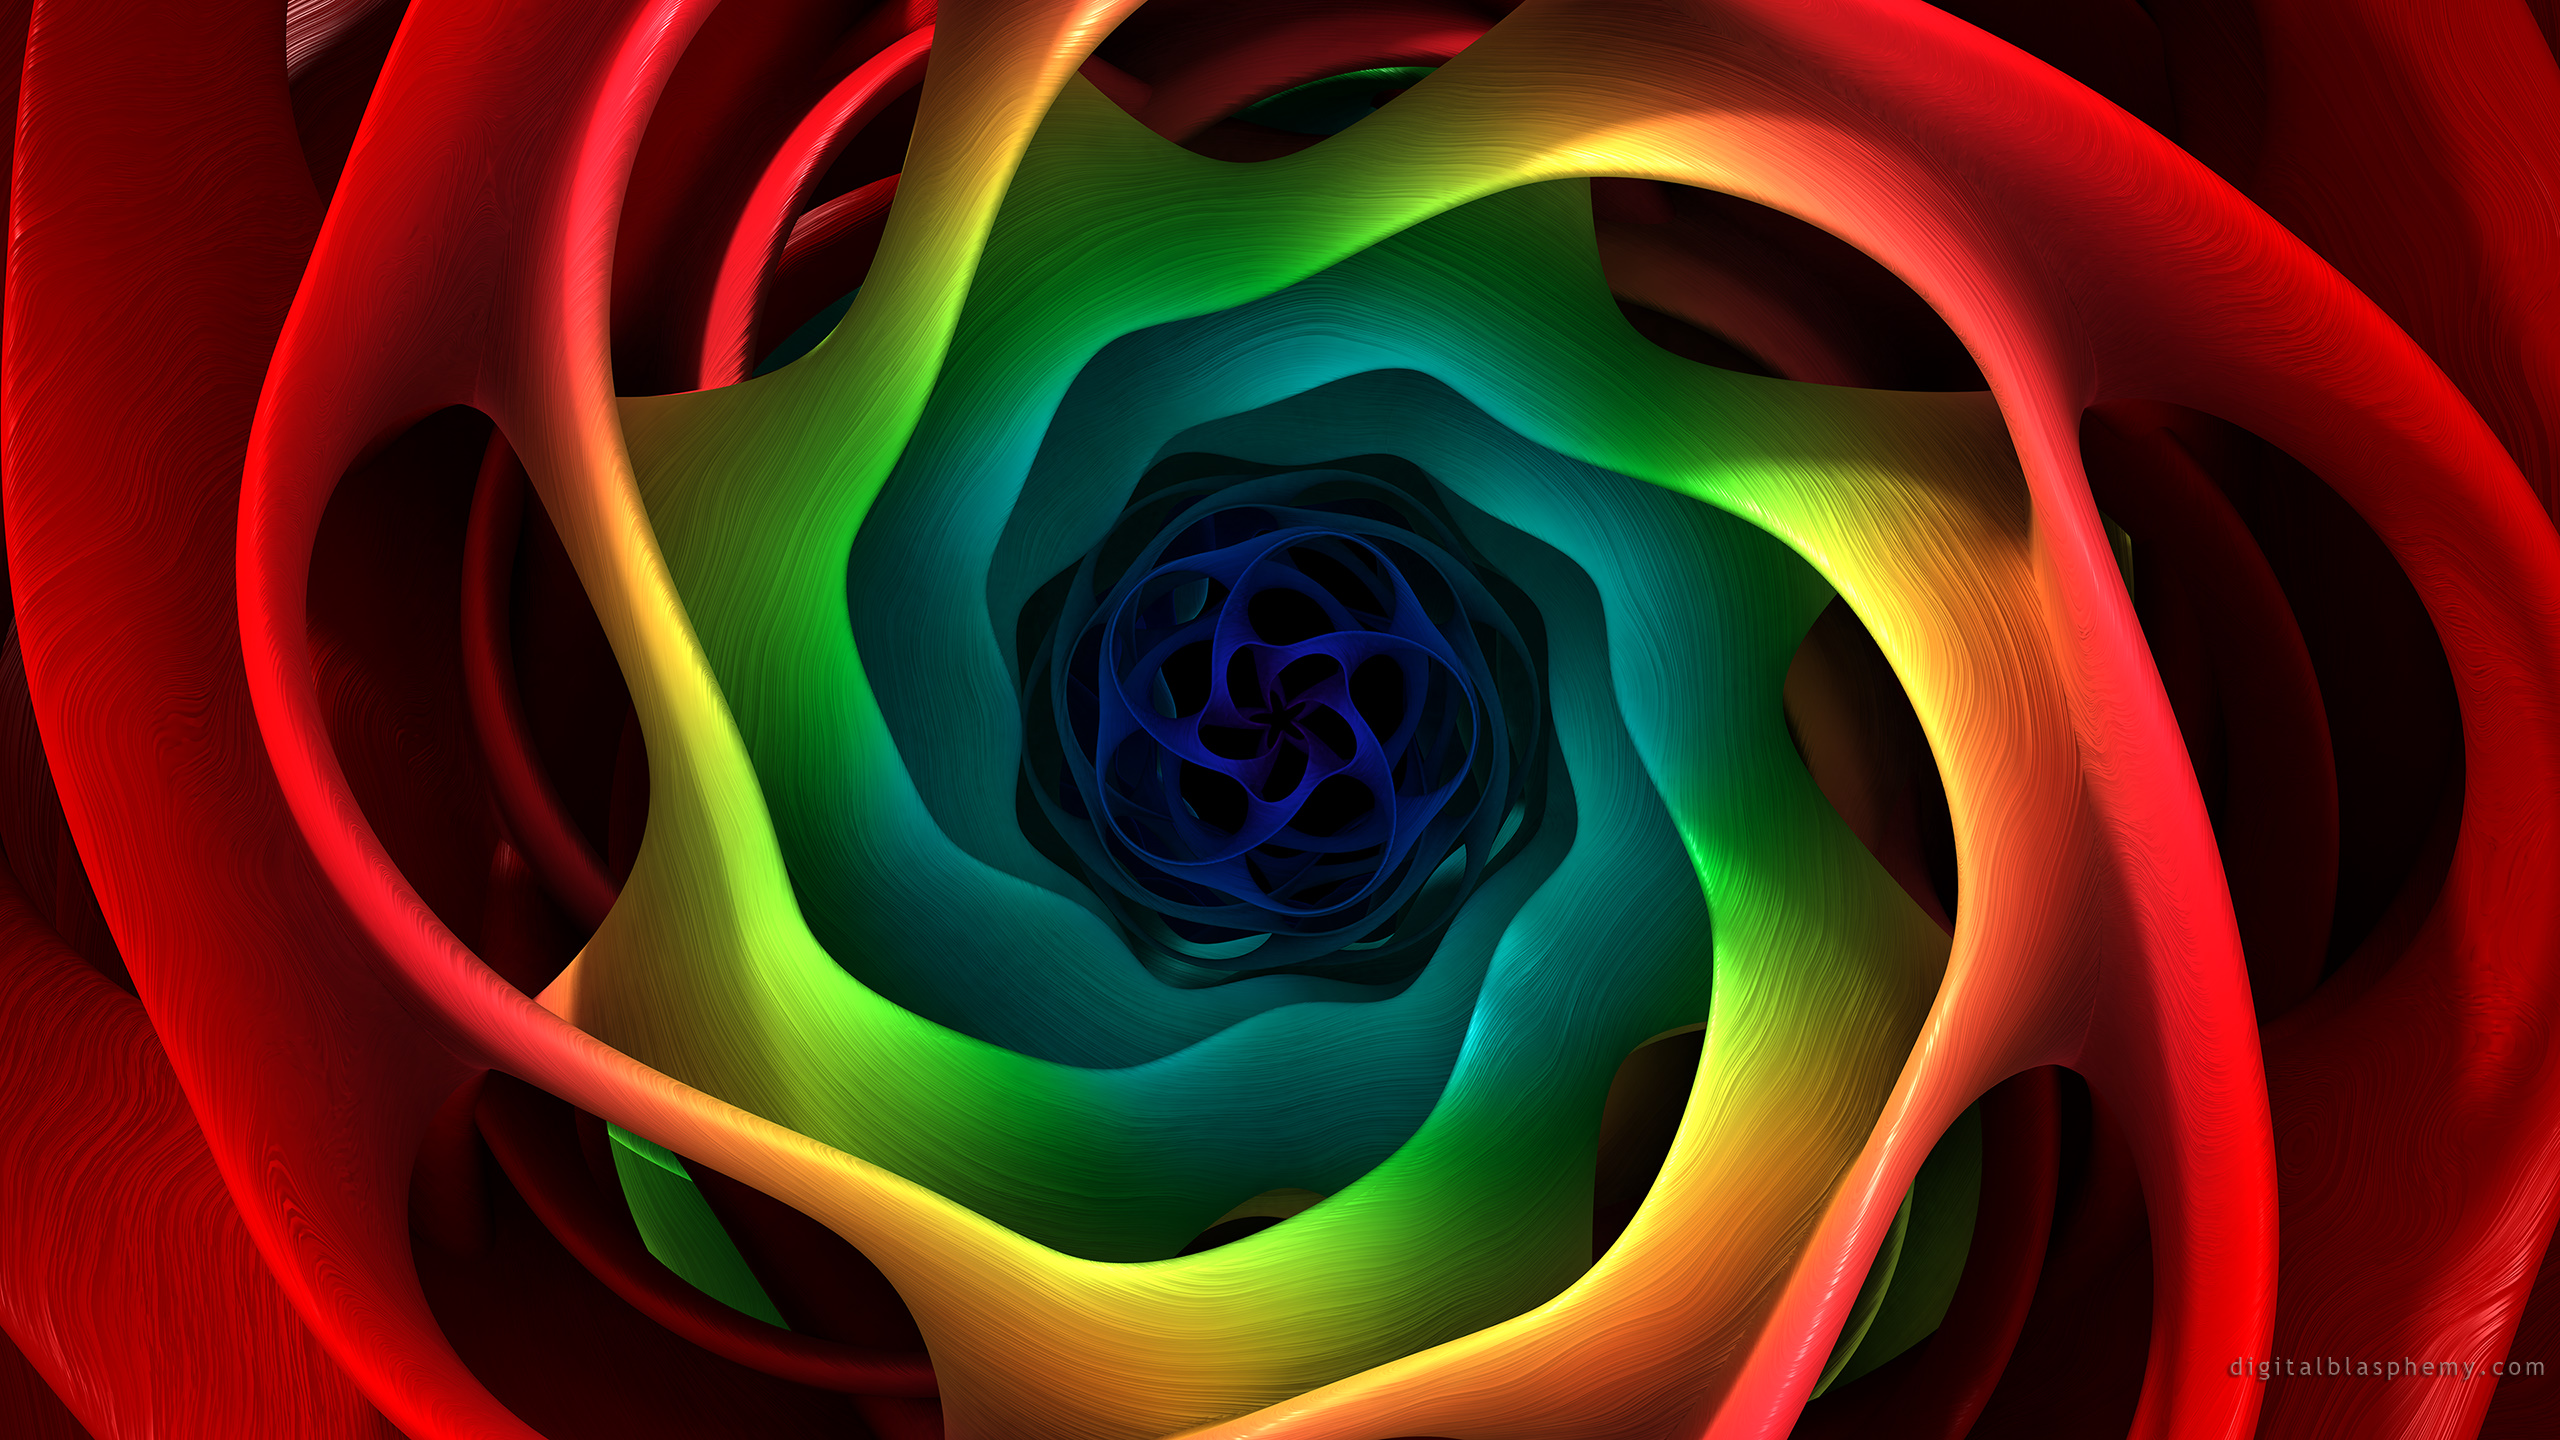

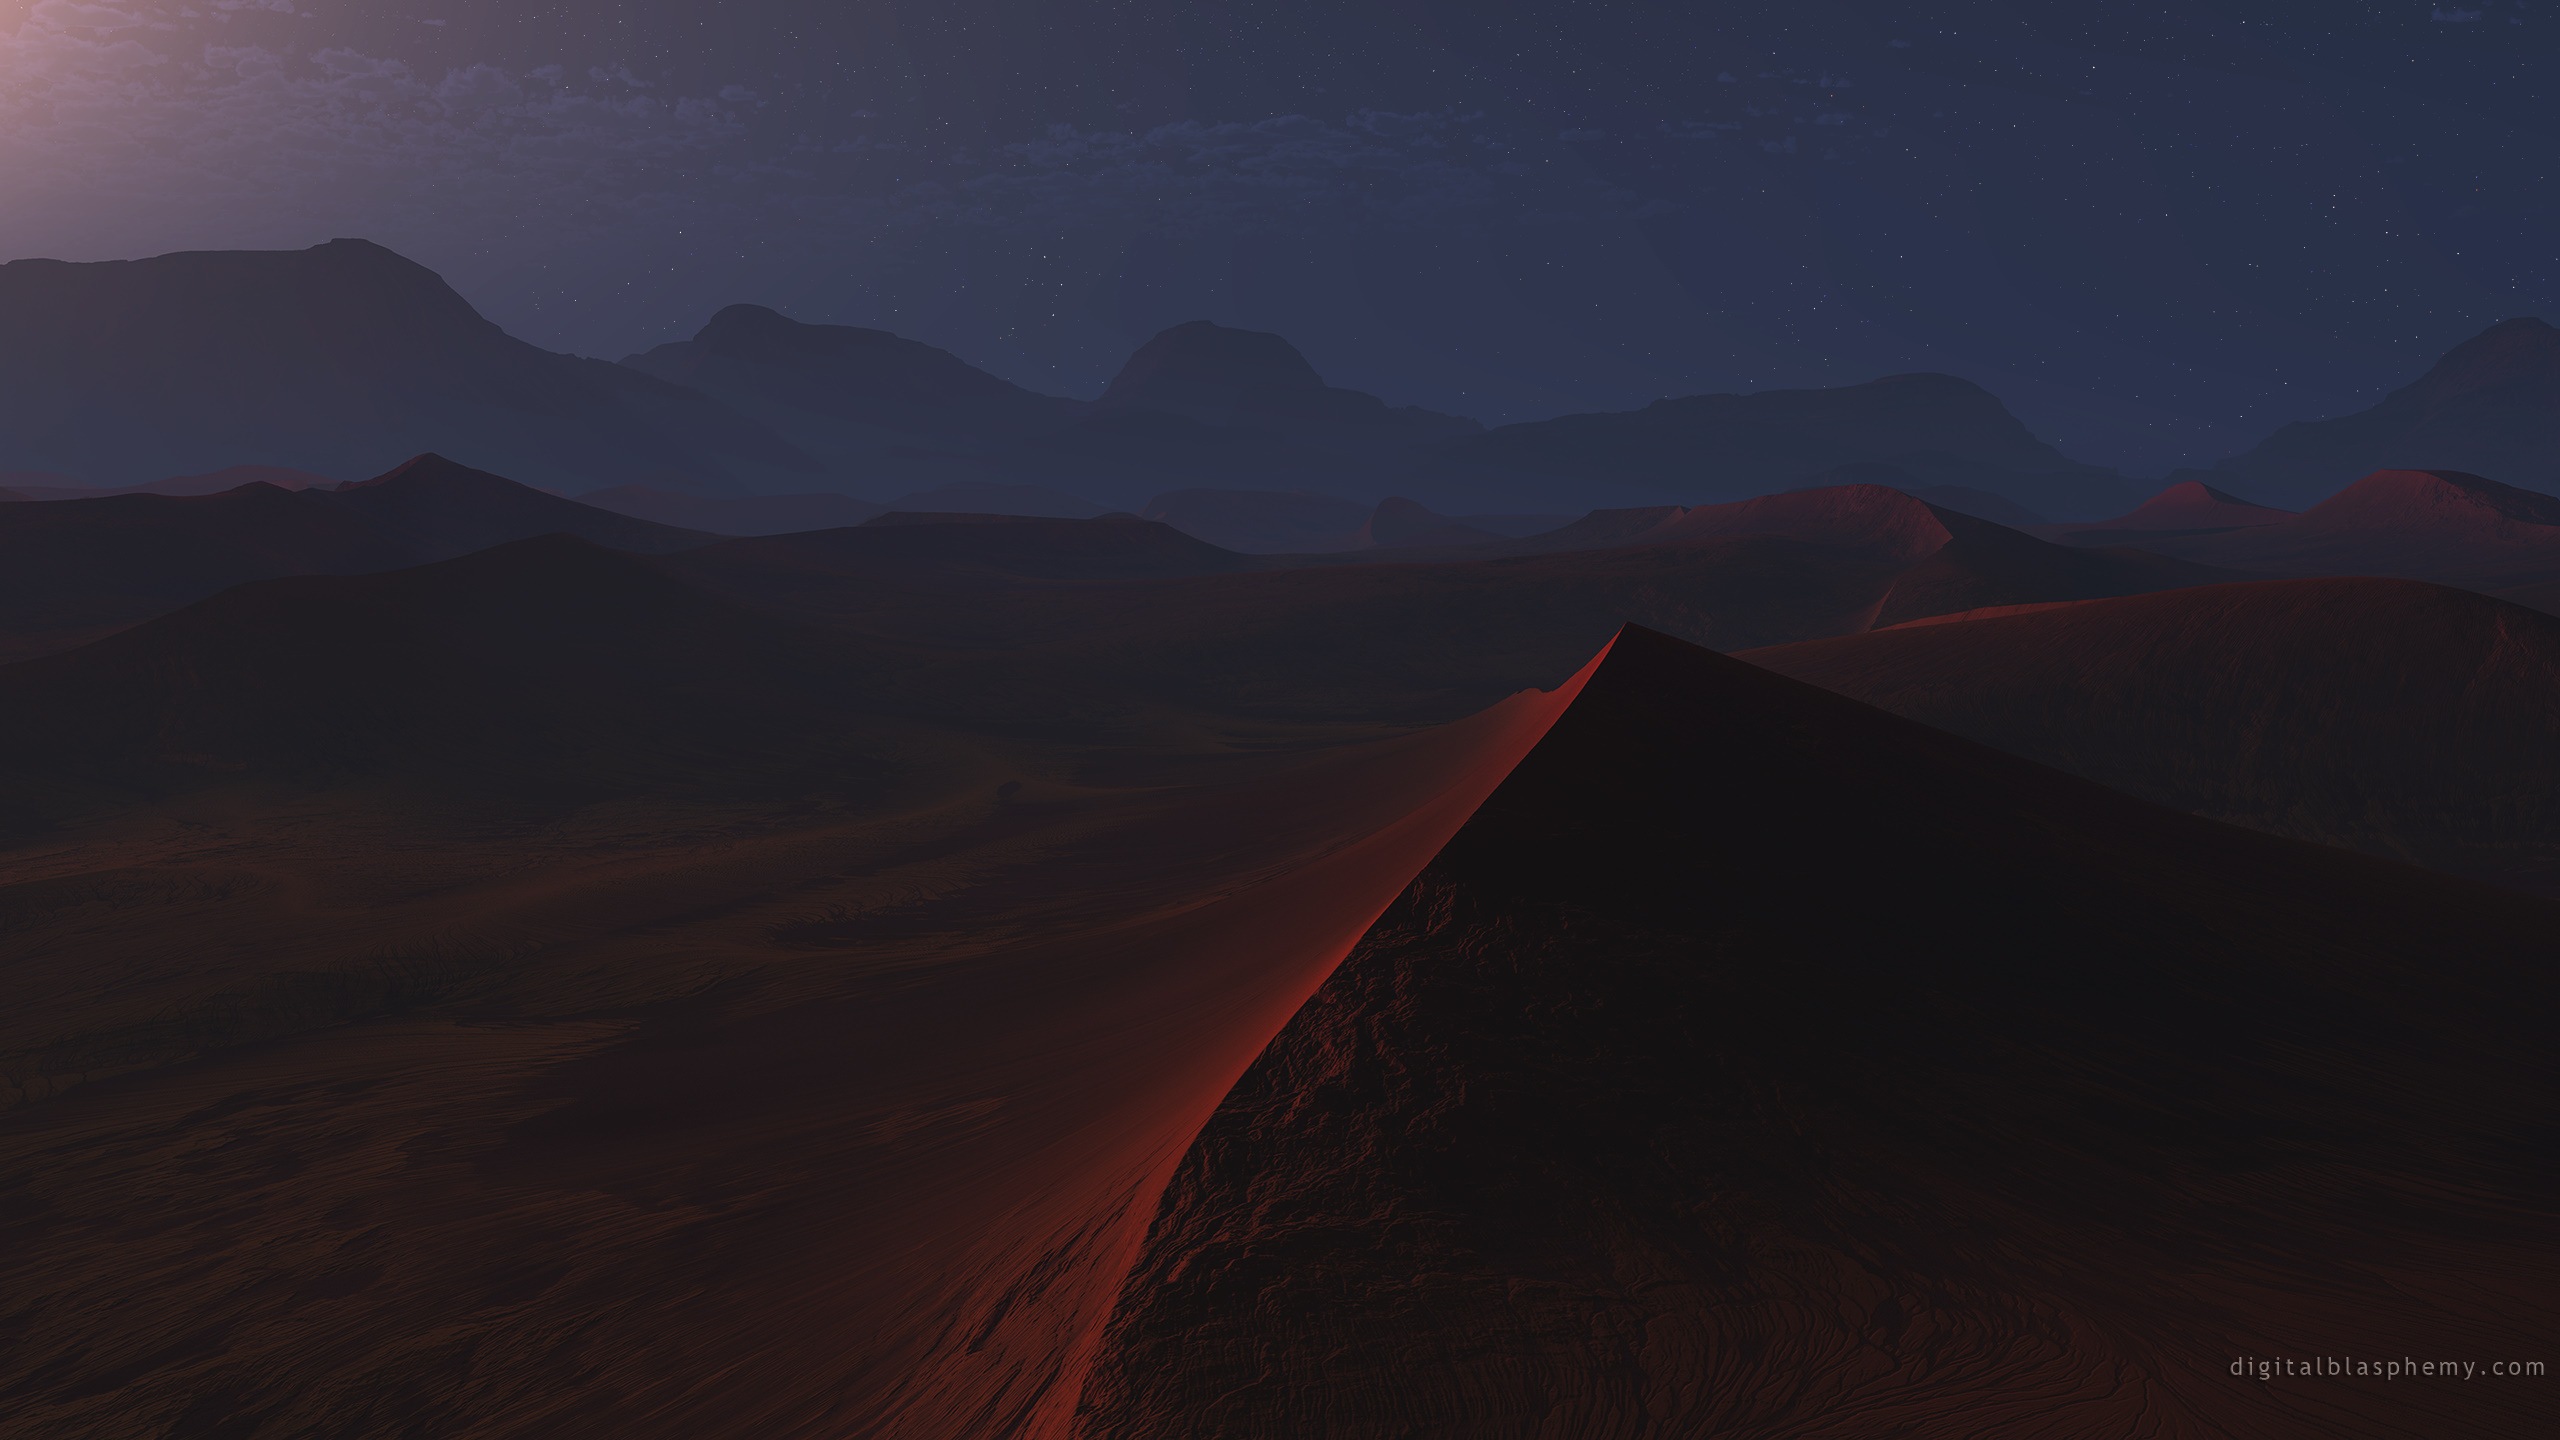

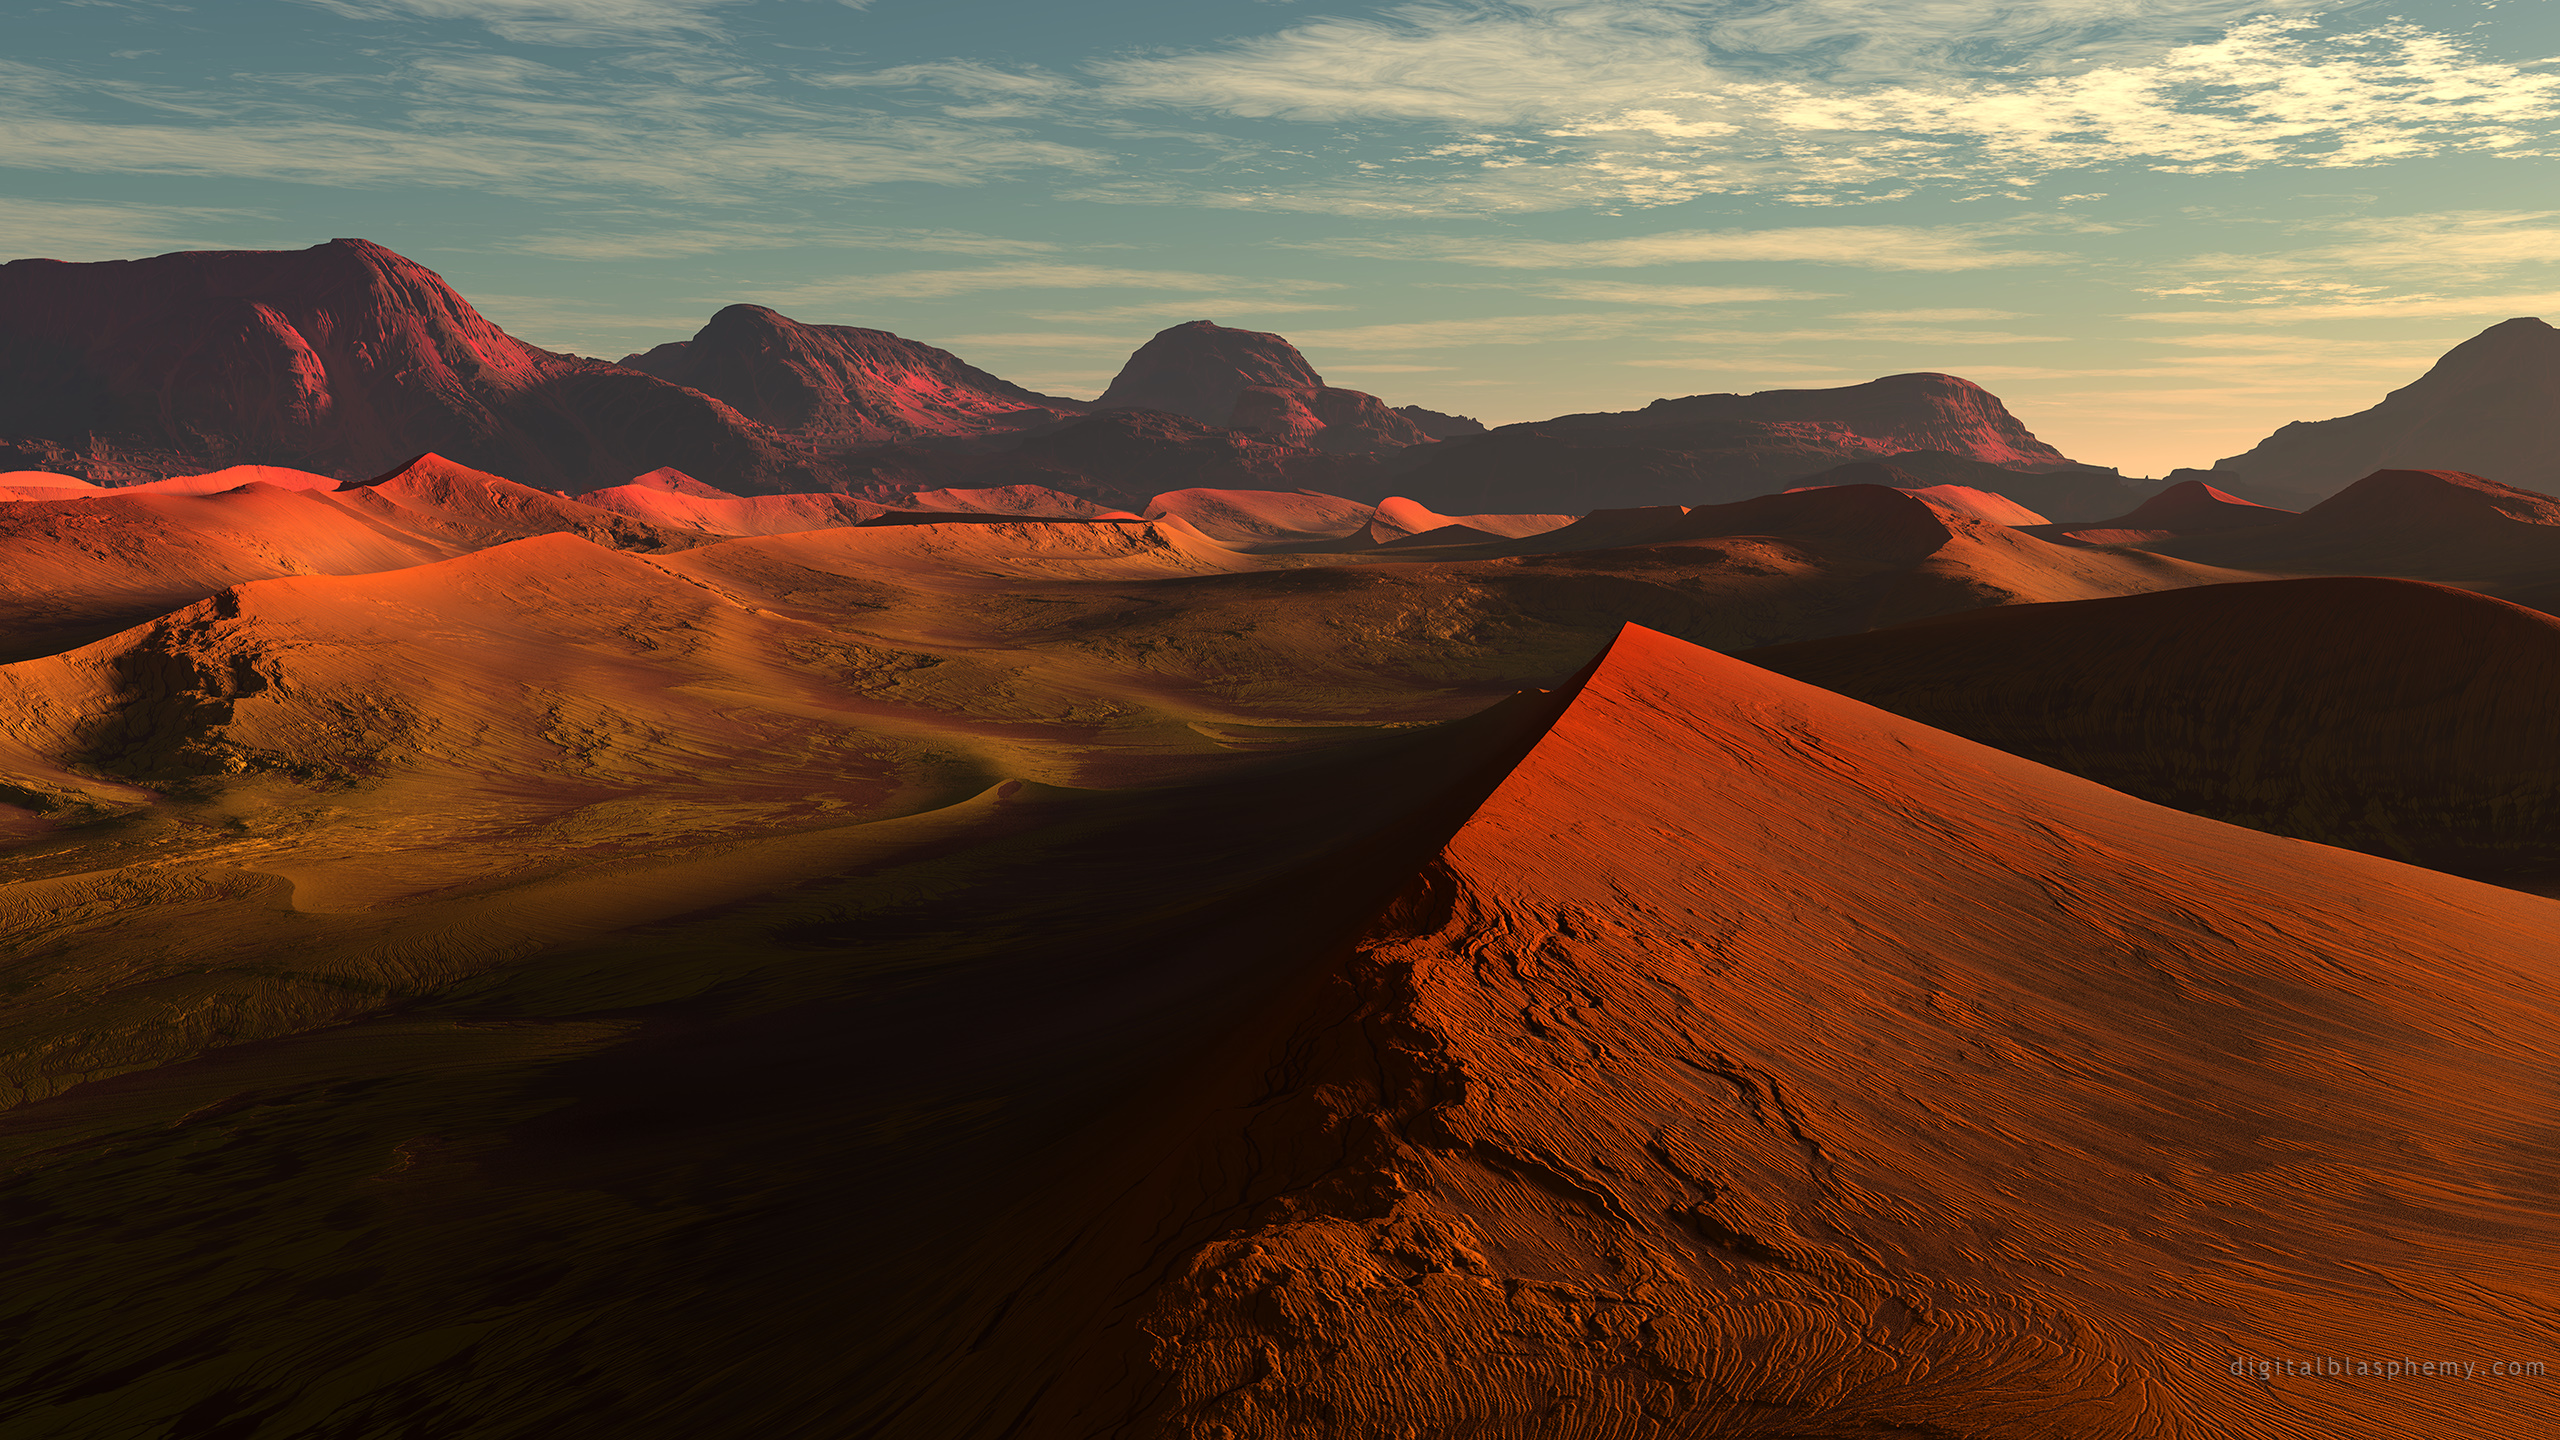

In [8]:
if downloaded and not DRY_RUN: show_images(downloaded[RESOLUTIONS[0]])